# Inputs! Change the parameters below and re-run the program to see how the outputs change
## <u>Roof and Rainfall:</u>
### Fill in green roof area (square feet), green roof capacity (inches), and rainwater harvest efficiency (as a proportion)
Here, green roof area is the approximate square footage of the green roof to be installed

Green roof capacity is the amount of rainfall (in inches) that the green roof is estimated to be able to absorb. A good rule of thumb is that a 3-4" green roof can absorb about 1 inch of rainfall 

*If you would like to analyze rainwater capture capacity without any green roof, set the green roof capacity equal to zero*

Rainwater harvest efficiency is the estimated proportion (between 0 and 1) of rainfall that will make it from the roof into a rainwater catchment tank. Here, an efficiency of 0 indicates that none of the rainfall will make it to the tank whereas an efficiency of 1 indicates that 100% of the rainfall will make it to a tank. If unsure, leave it at 0.5 for a conservative estimate

## <u>Frost Dates:</u>
### 1. Enter the first frost date as  "MM,dd"
### 2. Enter the last frost date as "MM, dd"
For example, if the first frost is on October 17th and the last frost is April 21:
1. first_frost_MM, first_frost_dd = (10,17)
2. last_frost_MM, last_frost_dd = (4,21) 

In [72]:
# Change the green numbers here to customize!
green_roof_area=7500 #in square feet
green_roof_capacity=1 #in inches
rainwater_harvest_efficiency=.5 #proportion/decimal between 0 and 1

first_frost_MM, first_frost_dd = (10,17) # Oct 17
last_frost_MM, last_frost_dd = (4,21) # April 21

In [73]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from scipy import stats
from matplotlib.backends.backend_pdf import PdfPages

In [74]:
df=pd.read_csv('NYC_Rainfall_Data.csv',parse_dates=[2],index_col=2)

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7702 entries, 2000-01-01 to 2021-01-31
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   STATION  7702 non-null   object 
 1   NAME     7702 non-null   object 
 2   PRCP     7702 non-null   float64
 3   SNOW     7700 non-null   float64
 4   SNWD     7594 non-null   float64
dtypes: float64(3), object(2)
memory usage: 361.0+ KB


# How much is the green roof absorbing per year on average?

In [76]:
grnrf=df.copy()
capture=[]
for a in grnrf['PRCP']:
    if a<=green_roof_capacity:
        capture.append(a)
    elif a>green_roof_capacity:
        capture.append(green_roof_capacity)
grnrf['CAPTURE_inches']=capture
grnrf_annual=grnrf.groupby(by=grnrf.index.year).sum()
green_roof_gallons=[]
for b in grnrf_annual['CAPTURE_inches']:
    green_roof_gallons.append(b*green_roof_area*.623)
grnrf_annual['GAL']=green_roof_gallons
grnrf_annual_current=grnrf_annual[grnrf_annual.index<2021]
grnrf_annual_current.iloc[:,3:]

,CAPTURE_inches,GAL
DATE,,
2000,38.67,180685.575
2001,31.68,148024.800
2002,37.31,174330.975
2003,49.21,229933.725
2004,41.35,193207.875
2005,40.21,187881.225
2006,46.06,215215.350
2007,42.81,200029.725
2008,42.85,200216.625


Now, visualized

Average amount of rainfall captured = 193964.38 gallons per year


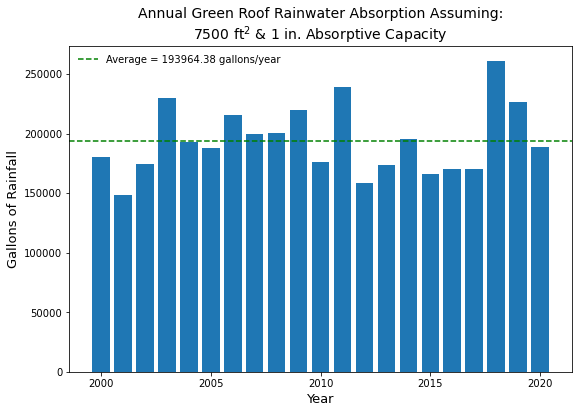

In [77]:
grnrf_avg=grnrf_annual_current.GAL.mean()
print ('Average amount of rainfall captured = {:.2f} gallons per year'.format(grnrf_avg))
fig,ax=plt.subplots()
fig.set_size_inches(9,6)
ax.bar(grnrf_annual_current.index,grnrf_annual_current.GAL)
ax.set_ylabel('Gallons of Rainfall',fontsize=13)
ax.set_xlabel('Year',fontsize=13)
ax.set_title('Annual Green Roof Rainwater Absorption Assuming:\n{} ft$^2$ & {} in. Absorptive Capacity'\
             .format(green_roof_area,green_roof_capacity),fontsize=14)
ax.axhline(y=grnrf_avg,color='g',linestyle='--',linewidth=1.5,label='Average = {:.2f} gallons/year'.format(grnrf_avg))
ax.legend(loc='best',fontsize=10,frameon=False)
fig.savefig('Green_Roof_Rainwater_Capture_Yield.pdf')

## Beyond a Green Roof
### Here we are trimming the data to look at the rainfall amounts left over that the green roof cannot account for

In [78]:
#eliminating all precip. less than 1 inch since "caught" by green roof
#creating a 'net' section to account for what green roof captures
df2=df[df.PRCP>green_roof_capacity]
net=[]
for a in df2['PRCP']:
    net.append(a-green_roof_capacity)
df2['NET_PRCP']=net
#There may be a warning message here but that's alright for our purposes

<ipython-input-78-ca52dc472d8e>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['NET_PRCP']=net


## Frost Dates:
### 1. Enter the first frost date as  "MM,dd"
### 2. Enter the last frost date as "MM, dd"
For example, if the first frost is on October 17th and the last frost is April 21:
1. first_frost_MM, first_frost_dd = (10,17)
2. last_frost_MM, last_frost_dd = (4,21) 

# Accounting for Frost Dates
### Rainwater catchment systems are emptied during the frost period to prevent pipes from freezing and cracking

In [79]:
month_day = pd.concat([
                df2.index.to_series().dt.month, 
                df2.index.to_series().dt.day
            ], axis=1).apply(tuple, axis=1)
nofrost=df2[(month_day > (last_frost_MM, last_frost_dd)) & (month_day < (first_frost_MM, first_frost_dd))]
nofrost.to_csv('nofrost.csv')

# Number of Rainy Days Unaccounted for

In [80]:
annual=nofrost.groupby(by=nofrost.index.year).count()
raindays=annual.PRCP

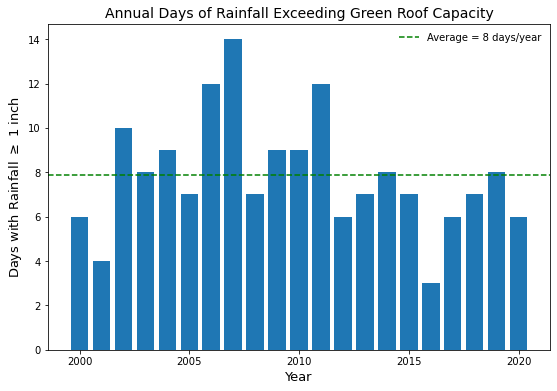

In [81]:
avvg=raindays.mean()
fig,ax=plt.subplots()
fig.set_size_inches(9,6)
ax.bar(annual.index,annual.PRCP)
ax.set_ylabel('Days with Rainfall $\geq$ 1 inch',fontsize=13)
ax.set_xlabel('Year',fontsize=13)
ax.set_title('Annual Days of Rainfall Exceeding Green Roof Capacity',fontsize=14)
ax.axhline(y=avvg,color='g',linestyle='--',linewidth=1.5,label='Average = {:.0f} days/year'.format(avvg))
ax.legend(loc=0,fontsize=10,frameon=False)
fig.savefig('Unaccounted_Days.pdf')

In [82]:
#how much rainfall would be missed every year assuming all rainfall <1 inch was captured
missedrain=nofrost.groupby(by=nofrost.index.year).sum()
missedrainmonth=nofrost.groupby(by=nofrost.index.month).mean()

In [83]:
missedrainmonth #average rainfall event size per month

,PRCP,SNOW,SNWD,NET_PRCP
DATE,,,,
4,1.977000,0.0,0.0,0.977000
5,1.515417,0.0,0.0,0.515417
6,1.748519,0.0,0.0,0.748519
7,1.591212,0.0,0.0,0.591212
8,2.028750,0.0,0.0,1.028750
9,1.765667,0.0,0.0,0.765667
10,1.920588,0.0,0.0,0.920588


^ Seems like pretty consistent rainfall with the heaviest months being April and August

# Annual Rainwater Capture Capacity

In [84]:
gal=[]
for a in missedrain['NET_PRCP']:
    gal.append(a*green_roof_area*.623*rainwater_harvest_efficiency)
missedrain['GAL']=gal
missedrain

,PRCP,SNOW,SNWD,NET_PRCP,GAL
DATE,,,,,
2000,11.35,0.0,0.0,5.35,12498.9375
2001,6.23,0.0,0.0,2.23,5209.8375
2002,17.06,0.0,0.0,7.06,16493.9250
2003,12.31,0.0,0.0,4.31,10069.2375
2004,18.64,0.0,0.0,9.64,22521.4500
2005,18.89,0.0,0.0,11.89,27778.0125
2006,20.24,0.0,0.0,8.24,19250.7000
2007,22.23,0.0,0.0,8.23,19227.3375
2008,13.42,0.0,0.0,6.42,14998.7250


Average amount of rainfall missed by green roof = 13925.16 gallons per year


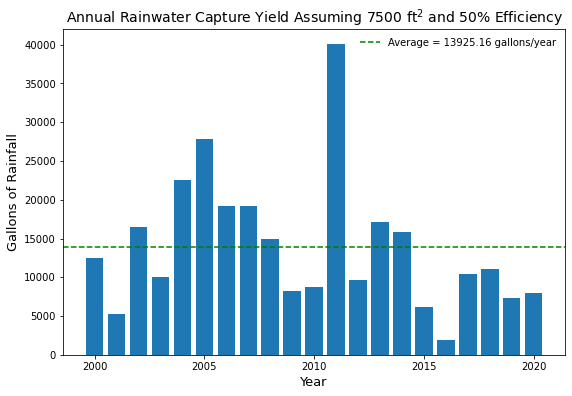

In [85]:
avg=missedrain.GAL.mean()
print ('Average amount of rainfall missed by green roof = {:.2f} gallons per year'.format(avg))
fig,ax=plt.subplots()
fig.set_size_inches(9,6)
ax.bar(missedrain.index,missedrain.GAL)
ax.set_ylabel('Gallons of Rainfall',fontsize=13)
ax.set_xlabel('Year',fontsize=13)
ax.set_title('Annual Rainwater Capture Yield Assuming {} ft$^2$ and {:.0f}% Efficiency'.format(green_roof_area,rainwater_harvest_efficiency*100),fontsize=14)
ax.axhline(y=avg,color='g',linestyle='--',linewidth=1.5,label='Average = {:.2f} gallons/year'.format(avg))
ax.legend(loc=0,fontsize=10,frameon=False)
fig.savefig('Rainwater_Capture_Yield.pdf')

## How big should the tank be?
### For this, we are going to look at the average amount of rainfall we could capture each month

In [86]:
each_month_capture=nofrost.groupby([(nofrost.index.year),(nofrost.index.month)]).sum()
gal2=[]
for a in each_month_capture['NET_PRCP']:
    gal2.append(a*green_roof_area*.623*rainwater_harvest_efficiency)
each_month_capture['GAL']=gal2
each_month_capture

PRCP  SNOW  SNWD  NET_PRCP        GAL
DATE DATE                                       
2000 5     1.07   0.0   0.0      0.07   163.5375
     6     2.62   0.0   0.0      1.62  3784.7250
     7     5.76   0.0   0.0      2.76  6448.0500
     9     1.90   0.0   0.0      0.90  2102.6250
2001 6     3.17   0.0   0.0      1.17  2733.4125
...         ...   ...   ...       ...        ...
2019 10    1.83   0.0   0.0      0.83  1939.0875
2020 7     3.96   0.0   0.0      1.96  4579.0500
     8     1.76   0.0   0.0      0.76  1775.5500
     9     2.34   0.0   0.0      0.34   794.3250
     10    1.36   0.0   0.0      0.36   841.0500

[95 rows x 5 columns]

In [87]:
print('The average monthly rainfall capture capacity\nof a roof of {} square feet at {}% efficiency\n\
(assuming a green roof captures rainfall events less than 1-inch)\nis about {:.1f} gallons'\
     .format(green_roof_area,rainwater_harvest_efficiency,each_month_capture.GAL.mean()))

The average monthly rainfall capture capacity
of a roof of 7500 square feet at 0.5% efficiency
(assuming a green roof captures rainfall events less than 1-inch)
is about 3078.2 gallons
